In [1]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 676.8 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 kB 34.5 MB/s eta 0:00:00


In [2]:
# Import core libraries
import pandas as pd
import nltk
import re # for regular expressons, comes with python
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
# Download necessary NLTK data
# NTLK provides extensive databanks of words, semmantics, and mappings (POS)
nltk.download('punkt') # punctuation
nltk.download('punkt_tab')
nltk.download('stopwords') # common words without much meaning
nltk.download('wordnet') # tagging parts of speech
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon') # for sentiment analysis

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data] Downloading package tagsets to /home/jovyan/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


True

In [4]:
# Sample customer reviews dataset
reviews = [
    "This product is absolutely amazing! I've been using it for 3 months and it works perfectly.",
    "The customer service was terrible. I waited 45 minutes on hold and then they couldn't help me.",
    "Not bad, but not great either. It does what it's supposed to do, but the quality could be better.",
    "I love this product! It exceeded my expectations in every way possible!",
    "DO NOT BUY THIS!!! It broke after just 2 weeks of normal use. Complete waste of money.",
    "It's okay I guess. Shipping was fast but the product is just average."
]

# Create a DataFrame for easier manipulation
df = pd.DataFrame({'review_text': reviews})

In [5]:
# Sentence tokenization
df['sentences'] = df['review_text'].apply(sent_tokenize)

# Word tokenization
df['tokens'] = df['review_text'].apply(word_tokenize)

# Examine the results
print("Original text:\n", df['review_text'][0])
print("\nSentence tokens:\n", df['sentences'][0])
print("\nWord tokens:\n", df['tokens'][0])

Original text:
 This product is absolutely amazing! I've been using it for 3 months and it works perfectly.

Sentence tokens:
 ['This product is absolutely amazing!', "I've been using it for 3 months and it works perfectly."]

Word tokens:
 ['This', 'product', 'is', 'absolutely', 'amazing', '!', 'I', "'ve", 'been', 'using', 'it', 'for', '3', 'months', 'and', 'it', 'works', 'perfectly', '.']


In [6]:
# Text normalization function
def normalize_text(tokens):
   # Convert to lowercase
   tokens = [token.lower() for token in tokens]
  
   # Remove punctuation
   # Via matching regex patterns - allows you to keep specific punctuation if wanted - can remove numbers as well if wanted
   tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)]
  
   # Alternative method using list of punctuation (commented out)
   # punctuation = list(string.punctuation)
   # tokens_alt = [token for token in tokens if token not in punctuation]
  
   return tokens


# Apply normalization
df['normalized_tokens'] = df['tokens'].apply(normalize_text)


# Compare before and after
print("Before normalization:", df['tokens'][0])
print("After normalization:", df['normalized_tokens'][0])

Before normalization: ['This', 'product', 'is', 'absolutely', 'amazing', '!', 'I', "'ve", 'been', 'using', 'it', 'for', '3', 'months', 'and', 'it', 'works', 'perfectly', '.']
After normalization: ['this', 'product', 'is', 'absolutely', 'amazing', 'i', 've', 'been', 'using', 'it', 'for', '3', 'months', 'and', 'it', 'works', 'perfectly']


In [7]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Add custom words to remove (commented out)
# stop_words.add('word')

# Function to remove stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply stopword removal
df['filtered_tokens'] = df['normalized_tokens'].apply(remove_stopwords)

# Compare before and after
print("Before stopword removal:", df['normalized_tokens'][0])
print("After stopword removal:", df['filtered_tokens'][0])

Before stopword removal: ['this', 'product', 'is', 'absolutely', 'amazing', 'i', 've', 'been', 'using', 'it', 'for', '3', 'months', 'and', 'it', 'works', 'perfectly']
After stopword removal: ['product', 'absolutely', 'amazing', 'using', '3', 'months', 'works', 'perfectly']


In [8]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


# Lemmatizer relies of part of speech to help
def get_wordnet_pos(treebank_tag):
  '''
  Translate nltk POS to wordnet tags
  '''
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN


# Stemming function
def stem_tokens(tokens):
   return [stemmer.stem(token) for token in tokens]


# Lemmatization function
def lemmatize_tokens(tokens):
   # Tag with pos
   tokens_tagged = pos_tag(tokens)
   pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]


   return [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]


# Apply stemming and lemmatization
df['stemmed_tokens'] = df['filtered_tokens'].apply(stem_tokens)
df['lemmatized_tokens'] = df['filtered_tokens'].apply(lemmatize_tokens)


# Compare results
print("Original filtered tokens:", df['filtered_tokens'][0])
print("After stemming:", df['stemmed_tokens'][0])
print("After lemmatization:", df['lemmatized_tokens'][0])

Original filtered tokens: ['product', 'absolutely', 'amazing', 'using', '3', 'months', 'works', 'perfectly']
After stemming: ['product', 'absolut', 'amaz', 'use', '3', 'month', 'work', 'perfectli']
After lemmatization: ['product', 'absolutely', 'amazing', 'use', '3', 'month', 'work', 'perfectly']


       review_length  word_count  avg_word_length  sentence_count
count       6.000000    6.000000         6.000000        6.000000
mean       84.666667   16.333333         4.112465        2.166667
std        11.944315    2.875181         0.418184        0.408248
min        69.000000   12.000000         3.700000        2.000000
25%        74.750000   14.750000         3.831933        2.000000
50%        88.500000   17.000000         4.011905        2.000000
75%        93.250000   17.750000         4.262255        2.000000
max        97.000000   20.000000         4.833333        3.000000


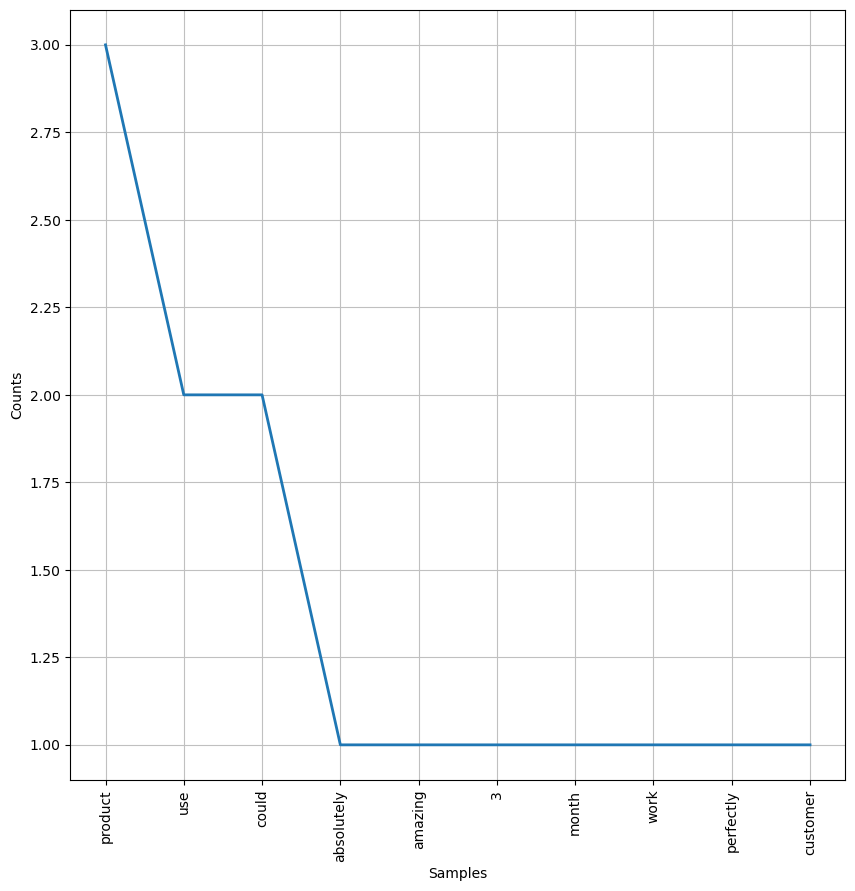

In [9]:
# Calculate text statistics
# Number of characters
df['review_length'] = df['review_text'].apply(len)

# Using normalized that includes stopwords
df['word_count'] = df['normalized_tokens'].apply(len)

df['avg_word_length'] = df['normalized_tokens'].apply(lambda x: sum(len(word) for word in x if word.isalnum()) / len([word for word in x if word.isalnum()]))
df['sentence_count'] = df['sentences'].apply(len)

# Display statistics
print(df[['review_length', 'word_count', 'avg_word_length', 'sentence_count']].describe())

# Visualize token freqency distributions
# Need to explode all review tokens into one list/series
fdist = FreqDist(df['lemmatized_tokens'].explode())
plt.figure(figsize=(10, 10))
# Can plot # of most common - in this case 10 most common tokens
fdist.plot(10);


In [10]:
from nltk.util import ngrams

# Function to generate n-grams
def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Generate bigrams
df['bigrams'] = df['lemmatized_tokens'].apply(lambda x: generate_ngrams(x, 2))

# Examine bigrams from the first review
print("Filtered tokens:", df['filtered_tokens'][0])
print("Bigrams:", df['bigrams'][0])

Filtered tokens: ['product', 'absolutely', 'amazing', 'using', '3', 'months', 'works', 'perfectly']
Bigrams: [('product', 'absolutely'), ('absolutely', 'amazing'), ('amazing', 'use'), ('use', '3'), ('3', 'month'), ('month', 'work'), ('work', 'perfectly')]


                                       tokens_joined sentiment
0  product absolutely amazing use 3 month work pe...  positive
1  customer service terrible wait 45 minute hold ...  negative
2     bad great either supposed quality could better  positive
3  love product exceed expectation every way poss...  positive
4   buy break 2 week normal use complete waste money  negative
5               okay guess ship fast product average  positive


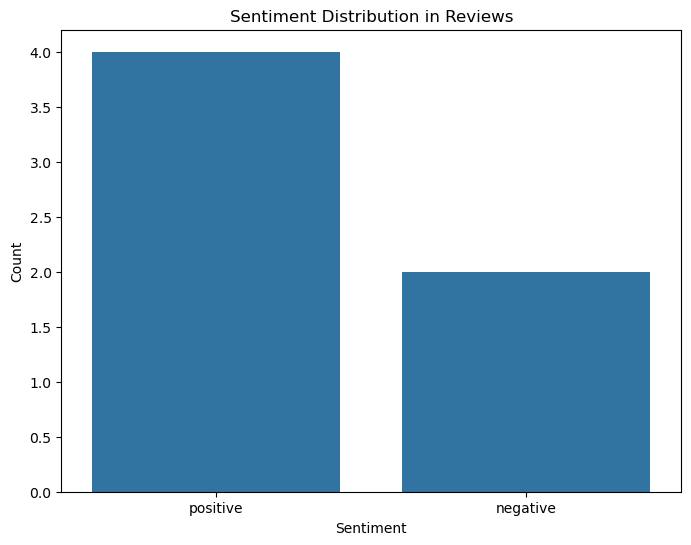

In [11]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()


# Need to join tokens back togather as one string for this to work
df['tokens_joined'] = df['lemmatized_tokens'].str.join(" ")


# Calculate sentiment scores
df['sentiment_scores'] = df['tokens_joined'].apply(lambda x: sia.polarity_scores(x))
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 'positive' if x['compound'] > 0.05
                                            else 'negative' if x['compound'] < -0.05
                                            else 'neutral')


# Display results
print(df[['tokens_joined', 'sentiment']])


# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()